In [1]:
import os, sys
sys.path.append('..') # Parent directory in path
from time import time, sleep
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
import scipy.stats as stats
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
import statsmodels.api as sm

pd.set_option("display.precision", 4)
#import pandas_market_calendars as mcal # NYSE Calendar

import matplotlib.pyplot as plt
plt.style.use('seaborn')
plt.rc("font", **{"size": 14})
plt.rc("figure", **{"figsize": (16,10)})
# import matplotlib.pylab as pl
from matplotlib import cm

# 1. base data
Daily S&P 500 options data and basic features.

In [4]:
# Import data from methodology_rates_iv
base_data = pd.concat([pd.read_hdf(os.path.join("data", "spx_iv_db_1.h5")), 
                 pd.read_hdf(os.path.join("data", "spx_iv_db_2.h5"))])
base_data.head()

,TS,EXP,STRIKE,TYPE,BID_CLOSE,MID_CLOSE,ASK_CLOSE,VOLUME,OPEN_INT,UNDERLYING_PRICE,DIFF,RANK,BUS_DAYS,CAL_DAYS,RATE_OLS,RATE_OPEN_INT,RATE_VOLUME,RATE_MONEYNESS,F_T_OLS,F_T_OPEN_INT,F_T_VOLUME,F_T_MONEYNESS,RATE,F_T,IV_BID,IV_MID,IV_ASK
0,2017-07-03,2017-07-21,2430,C,16.4,17.05,17.7,374,6981,2429.01,0.99,0,13,18,0.0211,0.022,0.0138,0.0162,2426.4748,2426.5318,2426.4955,2426.4824,0.022,2426.5318,0.0823,0.0852,0.0882
1,2017-07-03,2017-07-21,2430,P,19.9,20.50,21.1,281,6410,2429.01,0.99,0,13,18,0.0211,0.022,0.0138,0.0162,2426.4748,2426.5318,2426.4955,2426.4824,0.022,2426.5318,0.0824,0.0852,0.0879
2,2017-07-03,2017-07-21,2425,P,18.0,18.50,19.0,373,38136,2429.01,4.01,1,13,18,0.0211,0.022,0.0138,0.0162,2426.4748,2426.5318,2426.4955,2426.4824,0.022,2426.5318,0.0854,0.0877,0.0900
3,2017-07-03,2017-07-21,2425,C,19.4,20.05,20.7,194,42228,2429.01,4.01,1,13,18,0.0211,0.022,0.0138,0.0162,2426.4748,2426.5318,2426.4955,2426.4824,0.022,2426.5318,0.0848,0.0878,0.0908
4,2017-07-03,2017-07-21,2435,P,22.2,22.80,23.4,394,8399,2429.01,5.99,2,13,18,0.0211,0.022,0.0138,0.0162,2426.4748,2426.5318,2426.4955,2426.4824,0.022,2426.5318,0.0802,0.0830,0.0858


In [9]:
# based on expiration, see how many data points on every cross-section
base_data.groupby('EXP').count()['TS']

EXP
2017-07-21     3522
2017-08-18     8652
2017-09-15    13900
2017-10-20    17544
2017-11-17    18038
              ...  
2022-11-18    12840
2022-12-16    11922
2023-01-20     4604
2023-02-17     6434
2023-03-17     3826
Name: TS, Length: 69, dtype: int64

<AxesSubplot:xlabel='EXP'>

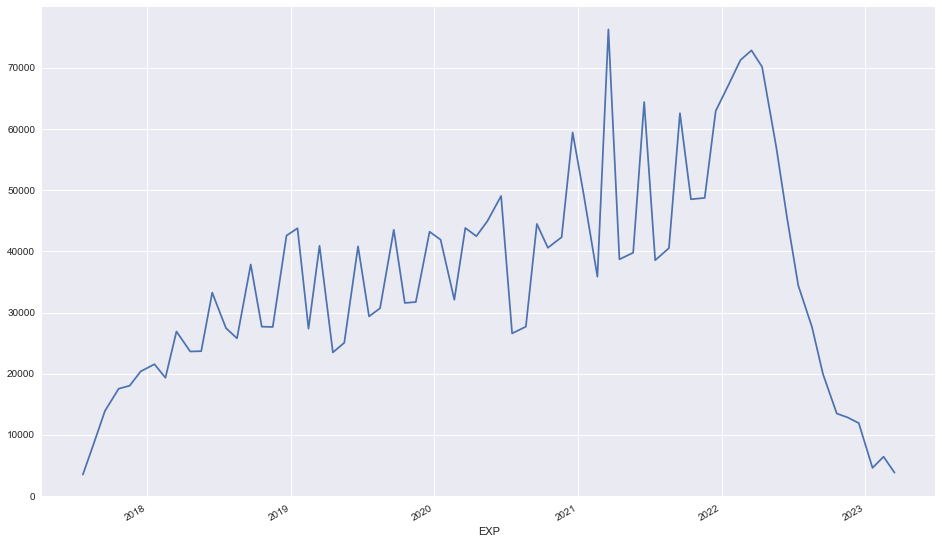

In [8]:
base_data.groupby('EXP').count()['TS'].plot()

In [10]:
# enrich basic feature
ATM_vols = base_data[base_data["RANK"]==0]
base_data = pd.merge(base_data, ATM_vols[["TS", "TYPE", "IV_BID", "IV_ASK"]], left_on=["TS", "TYPE"], right_on=["TS", "TYPE"], 
              suffixes=(None, "_ATM"), how="left")
base_data["MONEYNESS"] = base_data["UNDERLYING_PRICE"] - base_data["STRIKE"]

base_data["MONEYNESS_F"] = base_data["STRIKE"]/base_data["F_T"]
base_data["LOG_MONEYNESS_F"] = np.log(base_data["MONEYNESS_F"])
base_data["LOG_MONEYNESS_F_STANDARD_TIME"] = base_data["LOG_MONEYNESS_F"] / np.sqrt(base_data["CAL_DAYS"])

# df["LOG_MONEYNESS_F_STANDARD_STD"] = df["LOG_MONEYNESS_F"] / (np.sqrt(df["CAL_DAYS"])*(df["IV_BID_ATM"]+df["IV_ASK_ATM"])/2)

base_data["IV_BID_DIFF"] = base_data["IV_BID"] - base_data["IV_BID_ATM"]
base_data["IV_ASK_DIFF"] = base_data["IV_ASK"] - base_data["IV_ASK_ATM"]

base_data["IV_BID_RATIO"] = base_data["IV_BID"]/base_data["IV_BID_ATM"]
base_data["IV_ASK_RATIO"] = base_data["IV_ASK"]/base_data["IV_ASK_ATM"]
base_data

,TS,EXP,STRIKE,TYPE,BID_CLOSE,MID_CLOSE,ASK_CLOSE,VOLUME,OPEN_INT,UNDERLYING_PRICE,DIFF,RANK,BUS_DAYS,CAL_DAYS,RATE_OLS,RATE_OPEN_INT,RATE_VOLUME,RATE_MONEYNESS,F_T_OLS,F_T_OPEN_INT,F_T_VOLUME,F_T_MONEYNESS,RATE,F_T,IV_BID,IV_MID,IV_ASK,IV_BID_ATM,IV_ASK_ATM,MONEYNESS,MONEYNESS_F,LOG_MONEYNESS_F,LOG_MONEYNESS_F_STANDARD_TIME,IV_BID_DIFF,IV_ASK_DIFF,IV_BID_RATIO,IV_ASK_RATIO
0,2017-07-03,2017-07-21,2430,C,16.4,17.05,17.7,374,6981,2429.01,0.99,0,13,18,0.0211,0.0220,0.0138,0.0162,2426.4748,2426.5318,2426.4955,2426.4824,0.0220,2426.5318,0.0823,0.0852,0.0882,0.0823,0.0882,-0.99,1.0014,0.0014,0.0003,0.0000,0.0000,1.0000,1.0000
1,2017-07-03,2017-07-21,2430,C,16.4,17.05,17.7,374,6981,2429.01,0.99,0,13,18,0.0211,0.0220,0.0138,0.0162,2426.4748,2426.5318,2426.4955,2426.4824,0.0220,2426.5318,0.0823,0.0852,0.0882,0.0871,0.0908,-0.99,1.0014,0.0014,0.0003,-0.0048,-0.0026,0.9448,0.9714
2,2017-07-03,2017-07-21,2430,C,16.4,17.05,17.7,374,6981,2429.01,0.99,0,13,18,0.0211,0.0220,0.0138,0.0162,2426.4748,2426.5318,2426.4955,2426.4824,0.0220,2426.5318,0.0823,0.0852,0.0882,0.0950,0.0980,-0.99,1.0014,0.0014,0.0003,-0.0128,-0.0098,0.8658,0.9001
3,2017-07-03,2017-07-21,2430,C,16.4,17.05,17.7,374,6981,2429.01,0.99,0,13,18,0.0211,0.0220,0.0138,0.0162,2426.4748,2426.5318,2426.4955,2426.4824,0.0220,2426.5318,0.0823,0.0852,0.0882,0.1067,0.1097,-0.99,1.0014,0.0014,0.0003,-0.0244,-0.0215,0.7709,0.8039
4,2017-07-03,2017-07-21,2430,C,16.4,17.05,17.7,374,6981,2429.01,0.99,0,13,18,0.0211,0.0220,0.0138,0.0162,2426.4748,2426.5318,2426.4955,2426.4824,0.0220,2426.5318,0.0823,0.0852,0.0882,0.1167,0.1196,-0.99,1.0014,0.0014,0.0003,-0.0344,-0.0314,0.7049,0.7373
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25136353,2022-03-31,2023-03-17,5400,P,856.7,864.30,871.9,0,44,4530.41,869.59,64,242,351,0.0179,0.0183,0.0175,0.0185,4567.4657,4567.5692,4567.3136,4567.7985,0.0183,4567.5692,0.1431,0.1509,0.1583,0.2006,0.2172,-869.59,1.1822,0.1674,0.0089,-0.0575,-0.0589,0.7131,0.7288
25136354,2022-03-31,2023-03-17,5400,P,856.7,864.30,871.9,0,44,4530.41,869.59,64,242,351,0.0179,0.0183,0.0175,0.0185,4567.4657,4567.5692,4567.3136,4567.7985,0.0183,4567.5692,0.1431,0.1509,0.1583,0.2025,0.2175,-869.59,1.1822,0.1674,0.0089,-0.0595,-0.0592,0.7064,0.7277
25136355,2022-03-31,2023-03-17,5400,P,856.7,864.30,871.9,0,44,4530.41,869.59,64,242,351,0.0179,0.0183,0.0175,0.0185,4567.4657,4567.5692,4567.3136,4567.7985,0.0183,4567.5692,0.1431,0.1509,0.1583,0.1971,0.2186,-869.59,1.1822,0.1674,0.0089,-0.0540,-0.0603,0.7259,0.7242
25136356,2022-03-31,2023-03-17,5400,P,856.7,864.30,871.9,0,44,4530.41,869.59,64,242,351,0.0179,0.0183,0.0175,0.0185,4567.4657,4567.5692,4567.3136,4567.7985,0.0183,4567.5692,0.1431,0.1509,0.1583,0.1963,0.2275,-869.59,1.1822,0.1674,0.0089,-0.0533,-0.0692,0.7287,0.6959


In [11]:
# save the above processed base_data, we can directly use this in the next time.
# but csv file is large
base_data.to_csv("snp_base_data.csv",index=False)
# base_data = pd.read_csv("snp_base_data.csv")

#### * Question 1: should we calculate the greeks for every option as features?

# 2.vol curve fit
* hyperbola for example, maybe expand more model in future

Fixed a specific expiration, we can fit a set of vol curves(different DTE), x axis is moneyness, y axis is iv. \
When fitting the curve, we use out-of-the-money data to fit vol curve.


[Hyperbola Equation](https://www.desmos.com/calculator/phvqct3f4b):

$$\begin{aligned}
    y &= \sqrt{b^{2}\left(1+\frac{\left(x-c\right)^{2}}{a^{2}}\right)}+d(x-c) + e
\end{aligned}$$


#### * Question 2: the intuitively financial meaning of a,b,c,d,e?

In [ ]:
def hyperbola(x, a, b, c, d, e) -> float:
    """Tiltable hyperbola for scipy.optimize.curve_fit
    Asymptotes at 
    y=(-b/a+d)(x-c)+e
    y=( b/a+d)(x-c)+e"""
    return (b**2*(1+(x-c)**2/a**2))**0.5+d*(x-c)+e

def hyperbola_jac(x, a, b, c, d, e) -> np.ndarray:
    """Jacobian of the hyperbola with respect to each parameter"""
    ru = np.sqrt(b**2*(1+(x-c)**2/a**2))
    da = -(b**2 * (x-c)**2) / (a**3 * ru)
    db = np.sqrt(1+(x-c)**2/a**2)
    dc = -(b**2 * (x-c)) / (a**2 * ru) - d
    dd = x-c
    de = np.ones(len(x))
    return np.array([da, db, dc, dd, de]).T

def hyperbola_minimizer(a, b, c, d, e) -> float:
    """Returns the minimizer (x such that y is the minimum) of a hyperbola"""
    return ((a**2 * c * d**2 + d*(a**4 * b**2 - a**6 * d**2)**0.5 - b**2 * c)
            /(a**2 * d**2 - b**2))

def fit_hyp(df) -> np.ndarray:
    """Fits a hyperbola for a day's IV single curve"""
    curve = df.dropna()
    bounds = ((1e-4, 1e-4, 0, -2, -2), (1, 1, 1, 2, 2))
    popt, pcov = curve_fit(hyperbola, curve["LOG_MONEYNESS_F"], curve["IV_MID"]**2, 
                           jac=hyperbola_jac, bounds=bounds)
    return popt


* Need to do: for every expiration, generating the set of hyperbola parameters, which are the base/real data for prediction in the following parts.

* Ideal real dataset dimension: T* t* 5, T:expirations t:dte 5:param(a,b,c,d,e)

#### * Question 3: how to deal overlap vol curves on the same date, but fitted from different expiration?

# 3.vol curve models evaluation
loss function/evaluation standard:

$$\begin{aligned}
    ((iv_{mid} - iv_{fitted})*(vega+C))^2
\end{aligned}$$

We want to predict the best vol curve parameters in the following parts.

# 4. parameter prediction

If we can link the parameters in different expirations, then the base data is a T*5 time series matrix, then we utilize various ways to predict this data.

* evaluation standard: Pearson Correlation

## 4.1 multiple time series prediction on parameters
* ARMA, VARMA, GARCH, Kalman Enhancer, LSTM, LightGBM, Hidden Markov ...
* Penalize parameters based on their parametric meaning and correlation

## 4.2 build cross-sectional features for prediction

## 4.3 single feature analysis
* correlation, decision tree - feature importance

## 4.4 merge features together(feature engineering)
* OLS, T, DL